### Importing the Dependencies

In [1]:
!pip install chart-studio
!pip install plotly --upgrade
!pip install tensorflow
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"
warnings.filterwarnings('ignore')
%matplotlib inline

### Data Exploration

In [2]:
df = pd.read_csv('005380.KS.csv')

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,147500.0,148000.0,143500.0,144000.0,110097.859375,445332.0
1,2016-01-05,143000.0,145000.0,142000.0,143500.0,109715.578125,530496.0
2,2016-01-06,144000.0,145000.0,139000.0,140000.0,107039.601562,769406.0
3,2016-01-07,138500.0,140000.0,137500.0,137500.0,105128.171875,586187.0
4,2016-01-08,134500.0,138000.0,133500.0,136500.0,104363.593750,888701.0
...,...,...,...,...,...,...,...
2151,2024-10-14,250500.0,254000.0,248000.0,248500.0,248500.000000,307668.0
2152,2024-10-15,249500.0,249500.0,246000.0,246000.0,246000.000000,382087.0
2153,2024-10-16,246000.0,247000.0,242000.0,247000.0,247000.000000,799813.0
2154,2024-10-17,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2156 non-null   object 
 1   Open       2155 non-null   float64
 2   High       2155 non-null   float64
 3   Low        2155 non-null   float64
 4   Close      2155 non-null   float64
 5   Adj Close  2155 non-null   float64
 6   Volume     2155 non-null   float64
dtypes: float64(6), object(1)
memory usage: 118.0+ KB


### Data Cleaning and Manipulation 

In [5]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [6]:
df = df.dropna()
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df['Date'] =  pd.to_datetime(df['Date'])

In [8]:
print(f'This Data contains dates from {df.Date.min()} to {df.Date.max()}')
print(f'Total days are {(df.Date.max() - df.Date.min()).days}')

This Data contains dates from 2016-01-04 00:00:00 to 2024-10-18 00:00:00
Total days are 3210


In [9]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,2155,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2.155000e+03
mean,2020-05-25 11:20:14.477958144,167465.336427,169676.194896,165328.027842,167449.466357,146010.788946,8.557939e+05
min,2016-01-04 00:00:00,67200.000000,71000.000000,65000.000000,65900.000000,56764.781250,0.000000e+00
25%,2018-03-19 12:00:00,134250.000000,136000.000000,132500.000000,134000.000000,106803.421875,4.259755e+05
50%,2020-05-29 00:00:00,159000.000000,161500.000000,157000.000000,159500.000000,127808.257812,5.986560e+05
75%,2022-08-03 12:00:00,194500.000000,197000.000000,192500.000000,194950.000000,179134.976562,9.311945e+05
max,2024-10-18 00:00:00,299500.000000,299500.000000,293000.000000,298000.000000,298000.000000,1.993370e+07
std,NaN,42831.384768,43480.476781,42162.940924,42716.289042,46686.012264,9.388934e+05


### Visualisations

<Axes: >

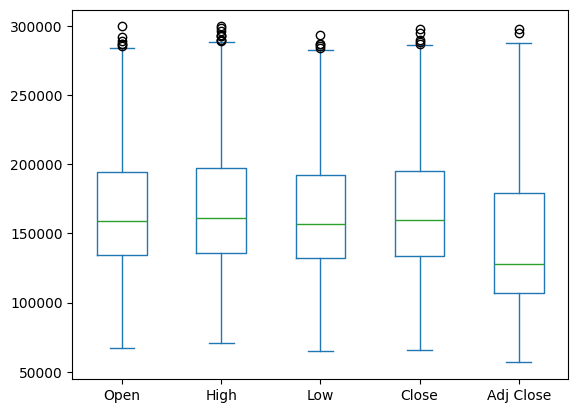

In [10]:
df[['Open', 'High', 'Low', 'Close', 'Adj Close']].plot(kind = 'box')

In [11]:
layout = go.Layout(
    title='Stock Prices of Hyundai',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    width=1000
)
hyundai_data = [go.Scatter(x=df['Date'], y=df['Close'], mode='lines')]
plot = go.Figure(data=hyundai_data, layout=layout)
plot.show()

### Model Training 

In [12]:
# Scaling the Data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])

# Displaying scaled values
df[['Date', 'Close']].head()

,Date,Close
0,2016-01-04,0.336493
1,2016-01-05,0.334339
2,2016-01-06,0.319259
3,2016-01-07,0.308488
4,2016-01-08,0.304179


In [13]:
# Defining the lookback period (60 days)
lookback = 60
X_data, Y_data = [], []

# Looping through data to create sequences safely
for i in range(lookback, len(df['Close'])):
    X_data.append(df['Close'].iloc[i-lookback:i].values) 
    Y_data.append(df['Close'].iloc[i])

# Convert them to numpy arrays
X_data, Y_data = np.array(X_data), np.array(Y_data)

# Reshaping the data to fit LSTM input (samples, time steps, features)
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1))

print(f"Shape of X_data: {X_data.shape}")
print(f"Shape of Y_data: {Y_data.shape}")

Shape of X_data: (2095, 60, 1)
Shape of Y_data: (2095,)


In [14]:
#Splitting the Data into training and testing datasets
train_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[:train_size], X_data[train_size:]
Y_train, Y_test = Y_data[:train_size], Y_data[train_size:]

print(f"Shape of X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Shape of X_train: (1676, 60, 1), Y_train: (1676,)
Shape of X_test: (419, 60, 1), Y_test: (419,)


In [15]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:].copy()  

In [16]:
# Adding the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Training the Epochs 
epochs = 30  
batch_size = 32
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
53/53 - 11s - 208ms/step - loss: 0.0100
Epoch 2/30
53/53 - 3s - 56ms/step - loss: 0.0011
Epoch 3/30
53/53 - 3s - 55ms/step - loss: 0.0011
Epoch 4/30
53/53 - 3s - 58ms/step - loss: 0.0011
Epoch 5/30
53/53 - 3s - 55ms/step - loss: 9.1575e-04
Epoch 6/30
53/53 - 3s - 55ms/step - loss: 8.6780e-04
Epoch 7/30
53/53 - 3s - 55ms/step - loss: 8.0833e-04
Epoch 8/30
53/53 - 3s - 58ms/step - loss: 8.1036e-04
Epoch 9/30
53/53 - 3s - 51ms/step - loss: 8.1175e-04
Epoch 10/30
53/53 - 3s - 58ms/step - loss: 6.9498e-04
Epoch 11/30
53/53 - 3s - 64ms/step - loss: 8.0489e-04
Epoch 12/30
53/53 - 3s - 60ms/step - loss: 6.4812e-04
Epoch 13/30
53/53 - 3s - 57ms/step - loss: 7.8392e-04
Epoch 14/30
53/53 - 4s - 67ms/step - loss: 6.1407e-04
Epoch 15/30
53/53 - 3s - 62ms/step - loss: 5.7969e-04
Epoch 16/30
53/53 - 3s - 62ms/step - loss: 5.6192e-04
Epoch 17/30
53/53 - 3s - 64ms/step - loss: 5.3505e-04
Epoch 18/30
53/53 - 3s - 63ms/step - loss: 5.0892e-04
Epoch 19/30
53/53 - 3s - 60ms/step - loss: 5.1276e-

In [18]:
# Making predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Debugging lengths
print(f"Length of predictions: {len(predictions)}")
print(f"Length of test_data: {len(test_data)}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Length of predictions: 419
Length of test_data: 431


In [19]:
# Ensure the correct slicing of test_data
lookback = 60  

# Defining the training and test sizes
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:].copy()  

# Creating X_test sequences 
X_test_data = []
for i in range(lookback, len(test_data)):
    X_test_data.append(test_data['Close'].iloc[i-lookback:i].values)

# Reshaping 
X_test_data = np.array(X_test_data)
X_test_data = np.reshape(X_test_data, (X_test_data.shape[0], X_test_data.shape[1], 1))

# Making Predictions 
predictions = model.predict(X_test_data)
predictions = scaler.inverse_transform(predictions)

# Adjusting the valid dataframe 
valid = test_data.iloc[lookback:lookback + len(predictions)].copy()  
valid['Predictions'] = predictions  

print("Actual Values:")
print(valid['Close'].tail(10))  

print("\nPredicted Values:")
print(valid['Predictions'].tail(10))  

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual Values:
2145    0.737182
2146    0.747953
2147    0.780267
2148    0.775959
2149    0.775959
2150    0.786730
2151    0.786730
2152    0.775959
2153    0.780267
2155    0.726411
Name: Close, dtype: float64

Predicted Values:
2145    246490.796875
2146    238539.000000
2147    235011.421875
2148    237756.812500
2149    240502.031250
2150    242308.953125
2151    244400.687500
2152    245601.937500
2153    244802.328125
2155    244320.109375
Name: Predictions, dtype: float32


In [20]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])

# Making predictions 
predictions = model.predict(X_test_data)
predictions = scaler.inverse_transform(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [21]:
print("Scaled Close Values:")
print(df['Close'].head()) 

print("Shape of predictions before inverse transform:", predictions.shape)

# Applying inverse transform
predictions = scaler.inverse_transform(predictions)

print("Predictions after inverse transform:")
print(predictions[:10])  

Scaled Close Values:
0    0.336493
1    0.334339
2    0.319259
3    0.308488
4    0.304179
Name: Close, dtype: float64
Shape of predictions before inverse transform: (371, 1)
Predictions after inverse transform:
[[0.5092938 ]
 [0.5096491 ]
 [0.52071357]
 [0.54107445]
 [0.55735475]
 [0.56104314]
 [0.5575523 ]
 [0.5465587 ]
 [0.5414751 ]
 [0.53776395]]


In [22]:
print(f"Length of X_test: {len(X_test)}")
print(f"Length of Y_test: {len(Y_test)}")

Length of X_test: 419
Length of Y_test: 419


In [23]:
print(f"Shape of X_test: {X_test.shape}")  

Shape of X_test: (419, 60, 1)


In [24]:
# Making new predictions
predictions = model.predict(X_test)

# Checking the length of predictions
print(f"Length of Predictions: {len(predictions)}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Length of Predictions: 419


In [25]:
# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

In [26]:
# Inverse transform Y_test to get actual values in original scale
actual_values = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [27]:
# Creating a comparison dataframe to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': actual_values.flatten(),
    'Predicted': predictions.flatten()
})

print(comparison_df.tail(10))

       Actual  Predicted
409  0.737182   0.778073
410  0.747953   0.743813
411  0.780267   0.728615
412  0.775959   0.740443
413  0.775959   0.752271
414  0.786730   0.760056
415  0.786730   0.769068
416  0.775959   0.774244
417  0.780267   0.770799
418  0.726411   0.768721


In [28]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculating the RMSE to measure the average prediction error 
rmse = np.sqrt(mean_squared_error(actual_values, predictions))

# R-squared (R²) score to assess the proportion of variance explained by the model.
r2 = r2_score(actual_values, predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 0.0251671367400573
R-squared: 0.9687298491484806


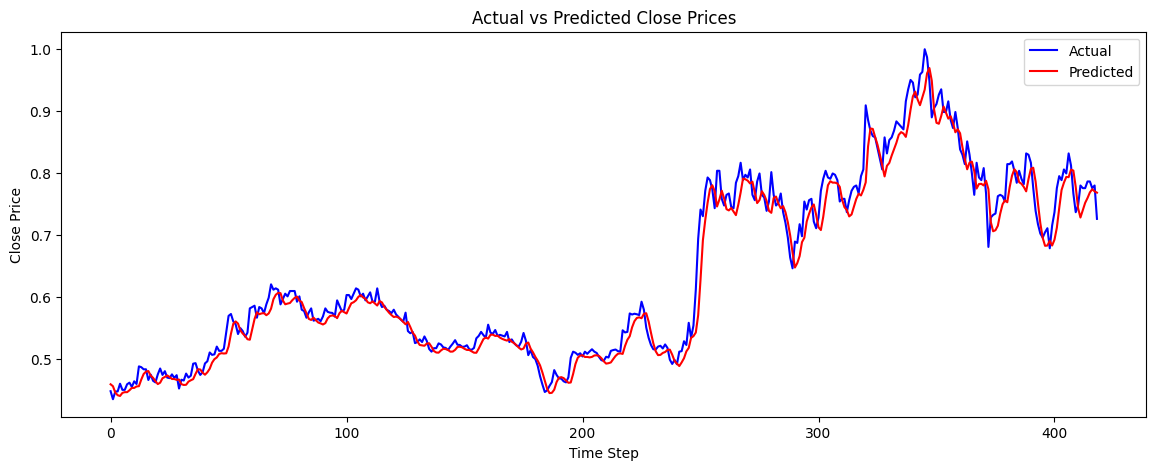

In [29]:
# Plotting Actual vs Predicted 
plt.figure(figsize=(14, 5))
plt.plot(comparison_df['Actual'], label='Actual', color='blue')
plt.plot(comparison_df['Predicted'], label='Predicted', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()